# 多因子模型(Multi-Factor Models)

## 项目简介

在这个项目里，其中用PCA方法建立数据风险模型。我将根据学术研究论文假设建立5种alpha因子数据化，进行评估，然后结合。最后，我会利用风险模型控制风险的前提下，用几种优化策略优化投资组合。

根据假设设定5种alpha因子:
- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

评估alpha因子4种方法:
- Factor-Weighted Returns
- Quantile Analysis
- Sharpe Ratio
- Turnover Analysis


原始数据取自Quotemedia及Sharadar

假设参考科研报告：
[Overnight Returns and Firm-Specific Investor Sentiment](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010)

### Install Packages(安装工具包)
版本:
`
alphalens==0.3.6
colour==0.1.5
cvxpy==1.0.3
cycler==0.10.0
numpy==1.16.2
pandas==0.22.0
plotly==2.2.3
pyparsing==2.2.0
python-dateutil==2.6.1
pytz==2017.3
requests==2.18.4
scipy==1.0.0
scikit-learn==0.19.1
six==1.11.0
tables==3.3.0
tqdm==4.19.5
zipline===1.3.0`

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Load Packages(加载工具包)

In [2]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import project_helper

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (21, 12)

## Data Bundle(注册数据包)

In [3]:
import os
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'project_4_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


## Build Pipeline Engine(建立Pipeline引擎)

In [4]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500)  # 排除低流动性股票
trading_calendar = get_calendar('NYSE')  # 使用纽交所时间数据
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Universe Tickers(概览选股范围)

In [5]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')  # 设置样本数据截止日期

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

## Get Returns(使用DataPortal获取回报数据)

In [6]:
from zipline.data.data_portal import DataPortal


data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

To make the code easier to read, we've built the helper function `get_pricing` to get the pricing from the data portal. 

In [7]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)
    
    history_pricing_window = data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')
                                                           
    return history_pricing_window

### View Data(概览回报数据)

In [8]:
five_year_returns = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0)

five_year_returns

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000
2011-01-21 00:00:00+00:00,0.007873,-0.041038,0.005544,-0.017911,0.000000,0.010642,-0.000853,-0.001952,-0.006569,-0.004113,...,0.000000,0.000615,0.015825,-0.003048,-0.000872,0.000000,-0.007590,0.009325,0.024020,0.000000


# Statistical Risk Model(统计风险模型)

## Fit PCA(将回报率数据进行主成分分析)

In [9]:
from sklearn.decomposition import PCA


def fit_pca(returns, num_factor_exposures, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    num_factor_exposures : int
        Number of factors for PCA
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    pca = PCA(n_components=num_factor_exposures, svd_solver="full")
    pca.fit(returns)
    
    return pca

### View Data(概览PCA成分)

In [10]:
num_factor_exposures = 20
pca = fit_pca(five_year_returns, num_factor_exposures, 'full')

pca.components_

array([[-0.04316847, -0.05874471, -0.03433256, ..., -0.03843904,
        -0.06092493, -0.01367163],
       [ 0.01955111,  0.19637679,  0.03451503, ...,  0.01749339,
        -0.01044197,  0.01892192],
       [-0.00993375,  0.07868756,  0.01133839, ..., -0.0157519 ,
         0.01261759,  0.01867875],
       ...,
       [-0.01174265,  0.01398085,  0.05143999, ...,  0.04125323,
         0.0035229 ,  0.03682367],
       [ 0.00526925, -0.04680674,  0.05716915, ...,  0.00671842,
        -0.02193923,  0.00833979],
       [-0.00535269, -0.01599057,  0.08414961, ..., -0.01540844,
         0.02188794,  0.01500221]])

#### PCA's percent of variance explained by each factor(降维后各因子解释方差百分比)

<Container object of 20 artists>

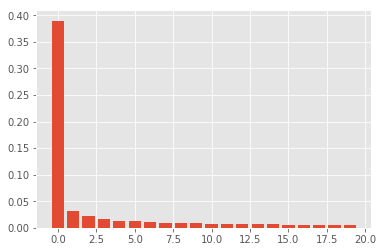

In [11]:
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)

## Factor Betas(从PCA模型中获取Factor Betas)

In [12]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    factor_betas = pd.DataFrame(
        data=pca.components_.T,
        index=factor_beta_indices,
        columns=factor_beta_columns)
    
    return factor_betas

### View Data(概览Factor Betas)

In [13]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, five_year_returns.columns.values, np.arange(num_factor_exposures))

risk_model['factor_betas']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Equity(0 [A]),-0.043168,0.019551,-0.009934,0.010540,-0.018198,0.010745,0.001129,0.039739,-0.013805,0.012737,-0.023840,-0.001417,0.020993,0.034610,-0.030489,0.033606,-0.011429,-0.011743,0.005269,-0.005353
Equity(1 [AAL]),-0.058745,0.196377,0.078688,0.082096,0.348478,-0.138082,0.071293,0.105248,-0.045890,-0.085478,0.003283,0.105343,0.067216,-0.044060,-0.022316,0.017263,-0.033108,0.013981,-0.046807,-0.015991
Equity(2 [AAP]),-0.034333,0.034515,0.011338,-0.025437,-0.008172,-0.013183,-0.060952,0.006549,-0.032654,-0.013515,0.028967,0.038365,-0.049605,-0.005246,-0.021970,0.029767,-0.011636,0.051440,0.057169,0.084150
Equity(3 [AAPL]),-0.034100,-0.001393,0.039467,-0.017213,-0.030470,-0.017571,0.023251,0.011430,-0.026568,-0.007719,0.026863,0.007319,0.004818,0.012886,0.052565,-0.073445,-0.031792,0.090794,-0.011189,0.042914
Equity(4 [ABBV]),-0.018031,0.025682,0.004352,-0.070782,0.013199,0.054277,-0.015678,0.040462,-0.012455,-0.035151,-0.051324,-0.040416,-0.051203,-0.018582,-0.011269,-0.042007,0.015886,0.045986,0.015993,0.065880
Equity(5 [ABC]),-0.028900,0.032592,-0.007421,-0.033552,-0.011521,0.026484,0.010850,-0.005704,0.013548,-0.029679,-0.031618,0.017152,-0.003050,0.026356,0.007879,0.008331,-0.018346,-0.013914,0.010620,-0.027396
Equity(6 [ABT]),-0.029057,0.029778,-0.029709,-0.035743,-0.011574,0.060201,-0.020040,0.040985,-0.018040,-0.006208,-0.031578,-0.023080,-0.014368,-0.000543,-0.019329,0.014288,-0.039381,0.010712,0.017120,0.002107
Equity(7 [ACN]),-0.043377,0.002569,0.004132,-0.003493,-0.054307,0.005374,0.002780,0.030432,-0.018802,-0.001783,-0.035404,-0.010932,0.026112,-0.012331,0.003221,0.017700,-0.002851,-0.012359,-0.014009,-0.038557
Equity(8 [ADBE]),-0.047303,0.026612,0.030571,-0.021147,-0.048388,-0.007087,0.007434,0.007471,0.014871,-0.001534,-0.012384,-0.006674,0.035007,-0.043366,0.010603,-0.006379,0.021273,-0.036388,0.001268,-0.048446
Equity(9 [ADI]),-0.047123,-0.003812,0.056008,-0.015538,-0.069462,-0.005604,0.100704,0.063077,0.001608,0.019130,0.011017,0.003487,-0.054657,-0.042238,-0.000143,-0.048432,0.003743,0.045833,0.014835,0.007686


## Factor Returns(从PCA模型中获取Factor Returns)

In [14]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    factor_returns = pd.DataFrame(
        data=pca.transform(returns),
        index=factor_return_indices,
        columns=factor_return_columns)
    
    return factor_returns

### View Data(概览Factor Returns)

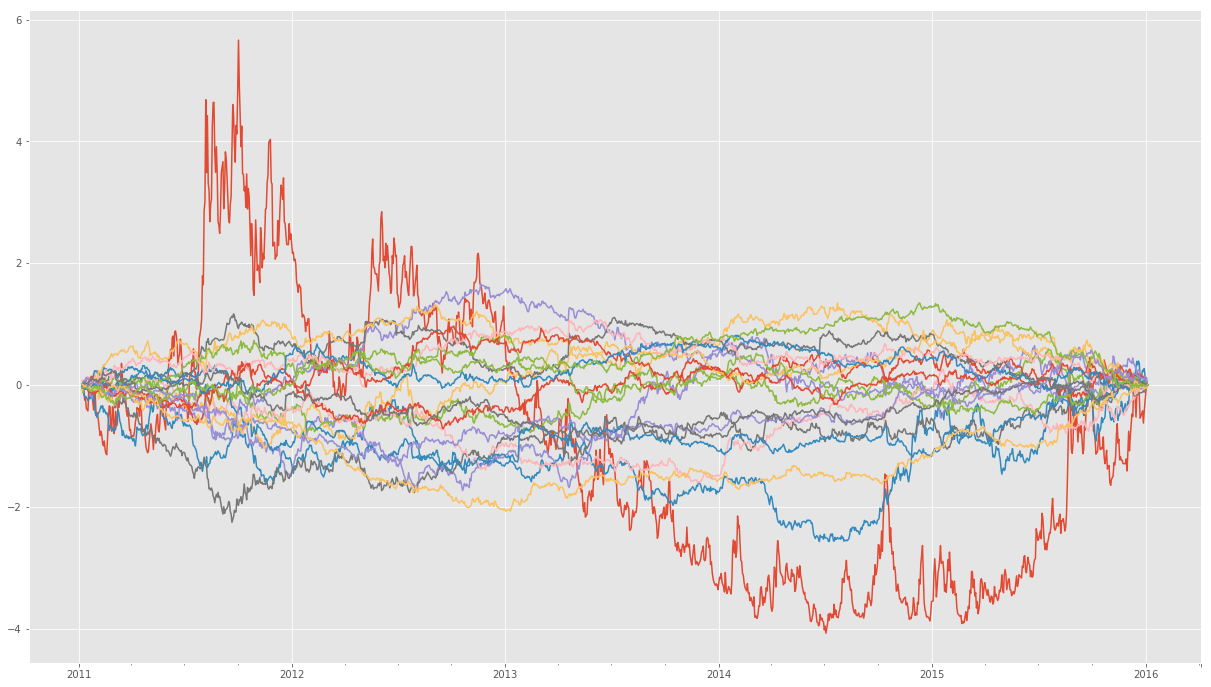

In [15]:
risk_model['factor_returns'] = factor_returns(
    pca,
    five_year_returns,
    five_year_returns.index,
    np.arange(num_factor_exposures))

plt.rcParams['figure.figsize'] = (21, 12)
risk_model['factor_returns'].cumsum().plot(legend=None)

## Factor Covariance Matrix

In [16]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """ 
    factor_cov_matrix = np.diag(factor_returns.var(axis=0, ddof=1)) * ann_factor
    
    return factor_cov_matrix

### View Data

In [17]:
ann_factor = 252
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

risk_model['factor_cov_matrix']

array([[14.01830425,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.10591127,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.77099145,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.61798821,  0.        ,
         0.        ,  0.        ,  0.        ,  

## Idiosyncratic Variance Matrix

In [18]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    common_returns = np.dot(factor_returns, factor_betas.T)
    
    residuals = returns - common_returns
    
    idiosyncratic_var_matrix = pd.DataFrame(
        data=np.diag(residuals.var())*ann_factor,
        index=returns.columns,
        columns=returns.columns)
    
    return idiosyncratic_var_matrix

### View Data

In [19]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(five_year_returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix']

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
Equity(0 [A]),0.022743,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(1 [AAL]),0.000000,0.051942,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(2 [AAP]),0.000000,0.000000,0.054355,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(3 [AAPL]),0.000000,0.000000,0.000000,0.048057,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(4 [ABBV]),0.000000,0.000000,0.000000,0.000000,0.030428,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(5 [ABC]),0.000000,0.000000,0.000000,0.000000,0.000000,0.01856,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(6 [ABT]),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.014827,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(7 [ACN]),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.021792,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(8 [ADBE]),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.034449,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000
Equity(9 [ADI]),0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.018999,...,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000


## Idiosyncratic Variance Vector

In [20]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    idiosyncratic_var_vector = pd.DataFrame(
        data=np.diag(idiosyncratic_var_matrix),
        index=returns.columns)
    
    return idiosyncratic_var_vector

### View Data

In [21]:
risk_model['idiosyncratic_var_vector'] = idiosyncratic_var_vector(five_year_returns, risk_model['idiosyncratic_var_matrix'])

risk_model['idiosyncratic_var_vector']

,0
Equity(0 [A]),0.022743
Equity(1 [AAL]),0.051942
Equity(2 [AAP]),0.054355
Equity(3 [AAPL]),0.048057
Equity(4 [ABBV]),0.030428
Equity(5 [ABC]),0.018560
Equity(6 [ABT]),0.014827
Equity(7 [ACN]),0.021792
Equity(8 [ADBE]),0.034449
Equity(9 [ADI]),0.018999


## Predict using the Risk Model(用风险模型$ \sqrt{X^{T}(BFB^{T} + S)X} $进行投资组合风险预测)

- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

In [22]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    """
    Get the predicted portfolio risk
    
    Formula for predicted portfolio risk is sqrt(X.T(BFB.T + S)X) where:
      X is the portfolio weights
      B is the factor betas
      F is the factor covariance matrix
      S is the idiosyncratic variance matrix

    Parameters
    ----------
    factor_betas : DataFrame
        Factor betas
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    weights : DataFrame
        Portfolio weights

    Returns
    -------
    predicted_portfolio_risk : float
        Predicted portfolio risk
    """
    assert len(factor_cov_matrix.shape) == 2

    X = weights
    B = factor_betas
    F = factor_cov_matrix
    S = idiosyncratic_var_matrix
    
    asset_var = np.dot(np.dot(B, F), B.T) + S
    portfolio_var = np.dot(np.dot(X.T, asset_var), X)
    predicted_portfolio_risk = np.sqrt(portfolio_var[0][0])
    
    return predicted_portfolio_risk

### View Data(用相同平均股票权重测试风险模型)

In [23]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    all_weights)

0.1609483997355891

# Create Alpha Factors(建立Alpha因子)

- Momentum 1 Year Factor
- Mean Reversion 5 Day Sector Neutral Factor
- Mean Reversion 5 Day Sector Neutral Smoothed Factor
- Overnight Sentiment Factor
- Overnight Sentiment Smoothed Factor

## Momentum 1 Year Factor(1年动量因子)
According to hypothesis "Higher past 12-month (252 days) returns are proportional to future return."

根据论文假设, "过去十二个月与未来的回报率呈部分正比", 建立该因子:

In [24]:
from zipline.pipeline.factors import Returns

def momentum_1yr(window_length, universe, sector):
    
    factor = Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()
    
    return factor

## Mean Reversion 5 Day Sector Neutral Factor(5日均值回归Sector中性因子)
According to hypothesis "Short-term outperformers(underperformers) compared to their sector will revert." 

根据论文假设, "在同一个类型(Sector)股票里，短期内(每周)表现较好的股票(或者较差的股票)将会反弹", 建立该因子:

In [25]:
def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral factor
    """
    factor = -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()
    
    return factor

### View Data(截取并概览两年“5日均值回归Sector中性因子”数据)

In [26]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)  # 由于两年前不是交易日，需再往前两日
sector = project_helper.Sector()
window_length = 5

pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral(window_length, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral
2014-01-03 00:00:00+00:00 Equity(0 [A])                                 0.853265
                          Equity(1 [AAL])                               1.626308
                          Equity(2 [AAP])                               0.649065
                          Equity(3 [AAPL])                              1.407522
                          Equity(4 [ABBV])                              1.458572
                          Equity(5 [ABC])                               0.145857
                          Equity(6 [ABT])                              -0.306300
                          Equity(7 [ACN])                               0.882436
                          Equity(8 [ADBE])                             -0.065636
                          Equity(9 [ADI])                               1.670065
                          Equity(10 [ADM])                              1.181444
                          Equity(11 [ADP])                              0.240664
                          Equity(12 [ADS])                             -1.691944
                          Equity(13 [ADSK])                            -0.357350
                          Equity(14 [AEE])                              0.342764
                          Equity(15 [AEP])                             -0.452157
                          Equity(16 [AES])                              0.503207
                          Equity(17 [AET])                              0.794922
                          Equity(18 [AFL])                              1.152272
                          Equity(19 [AGN])                             -1.480451
                          Equity(20 [AIG])                             -0.277129
                          Equity(21 [AIV])                             -0.379229
                          Equity(22 [AIZ])                              0.918901
                          Equity(23 [AJG])                             -0.824093
                          Equity(24 [AKAM])                             1.225201
                          Equity(25 [ALB])                              0.692822
                          Equity(26 [ALGN])                             1.086636
                          Equity(27 [ALK])                             -1.305422
                          Equity(28 [ALL])                             -0.488622
                          Equity(29 [ALLE])                             1.429401
...                                                                          ...
2016-01-05 00:00:00+00:00 Equity(460 [VRSN])                            1.486146
                          Equity(461 [VRTX])                           -1.158267
                          Equity(462 [VTR])                            -1.557423
                          Equity(463 [VZ])                             -1.429123
                          Equity(464 [WAT])                             0.473998
                          Equity(465 [WBA])                             1.215289
                          Equity(466 [WDC])                            -1.593062
                          Equity(467 [WEC])                            -0.138992
                          Equity(468 [WFC])                             0.359954
                          Equity(469 [WHR])                            -1.151139
                          Equity(471 [WM])                              0.381337
                          Equity(472 [WMB])                            -1.692852
                          Equity(473 [WMT])                            -1.528912
                          Equity(474 [WRK])                            -1.322206
                          Equity(475 [WU])                              0.545276
                          Equity(476 [WY])                              0.081970
                          Equity(477 [WYN])                             1.193906
                          Equity(478 [WYNN])                           -1.493

## Mean Reversion 5 Day Sector Neutral Smoothed Factor(5日均值回归Sector中性平滑因子)
Taking the output of the previous factor, create a smoothed version with simple moving average.

使用移动平均值平滑5日均值回归Sector中性因子数据.

In [27]:
from zipline.pipeline.factors import SimpleMovingAverage

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    """
    Generate the mean reversion 5 day sector neutral smoothed factor

    Parameters
    ----------
    window_length : int
        Returns window length
    universe : Zipline Filter
        Universe of stocks filter
    sector : Zipline Classifier
        Sector classifier

    Returns
    -------
    factor : Zipline Factor
        Mean reversion 5 day sector neutral smoothed factor
    """
    unsmoothed_factor = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    smoothed_factor = SimpleMovingAverage(
         inputs=[unsmoothed_factor], window_length=window_length, mask=universe) \
        .rank() \
        .zscore()
    return smoothed_factor

### View Data(概览两年“5日均值回归Sector中性平滑因子”数据)

In [28]:
pipeline = Pipeline(screen=universe)
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

Mean_Reversion_5Day_Sector_Neutral_Smoothed
2014-01-03 00:00:00+00:00 Equity(0 [A])                                          1.115808
                          Equity(1 [AAL])                                        1.728408
                          Equity(2 [AAP])                                        1.341887
                          Equity(3 [AAPL])                                       0.911608
                          Equity(4 [ABBV])                                       0.962658
                          Equity(5 [ABC])                                        0.773043
                          Equity(6 [ABT])                                        0.488622
                          Equity(7 [ACN])                                       -0.459450
                          Equity(8 [ADBE])                                       0.816801
                          Equity(9 [ADI])                                        0.948072
                          Equity(10 [ADM])                                       0.736579
                          Equity(11 [ADP])                                       0.320886
                          Equity(12 [ADS])                                      -1.597137
                          Equity(13 [ADSK])                                      0.080221
                          Equity(14 [AEE])                                       0.116686
                          Equity(15 [AEP])                                       0.218786
                          Equity(16 [AES])                                      -0.751165
                          Equity(17 [AET])                                      -1.093929
                          Equity(18 [AFL])                                      -0.072929
                          Equity(19 [AGN])                                      -0.379229
                          Equity(20 [AIG])                                       1.050172
                          Equity(21 [AIV])                                      -0.145857
                          Equity(22 [AIZ])                                       0.670943
                          Equity(23 [AJG])                                      -0.561550
                          Equity(24 [AKAM])                                      1.677358
                          Equity(25 [ALB])                                       1.356472
                          Equity(26 [ALGN])                                      1.327301
                          Equity(27 [ALK])                                       0.576136
                          Equity(28 [ALL])                                       0.021879
                          Equity(29 [ALLE])                                      1.655480
...                                                                                   ...
2016-01-05 00:00:00+00:00 Equity(460 [VRSN])                                     1.122628
                          Equity(461 [VRTX])                                    -1.621574
                          Equity(462 [VTR])                                     -1.607318
                          Equity(463 [VZ])                                      -1.685724
                          Equity(464 [WAT])                                     -1.008583
                          Equity(465 [WBA])                                      0.980072
                          Equity(466 [WDC])                                     -1.222417
                          Equity(467 [WEC])                                     -0.787621
                          Equity(468 [WFC])                                      0.723471
                          Equity(469 [WHR])                                      0.374209
                          Equity(471 [WM])                                      -0.538149
                          Equity(472 [WMB])                                     -1.657213
                          Equity(473 [WMT])                                     -1.414

## Overnight Sentiment Factor(隔夜情绪波动因子)
For this factor, were using the hypothesis from the paper [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010). 

The paper indicates that high overnight returns underperform in a long-term.

这个因子源自研究报告假设 [_Overnight Returns and Firm-Specific Investor Sentiment_](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010).

研究报告提到持续走高的隔夜回报率长期表现不佳，反之，持续走低的隔夜回报率长期表现较好。

In [29]:
from zipline.pipeline.data import USEquityPricing


class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    factor = TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()
    return factor

## Overnight Sentiment Smoothed Factor(隔夜情绪波动平滑因子)

In [30]:
def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

## Combine the Factors to a single Pipeline(将所有因子添加到Pipeline)

In [31]:
universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(5, universe, sector),
    'Mean_Reversion_5Day_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment(2, 5, universe),
    'Overnight_Sentiment')
pipeline.add(
    overnight_sentiment_smoothed(2, 5, universe),
    'Overnight_Sentiment_Smoothed')
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

all_factors.head()

Mean_Reversion_5Day_Sector_Neutral  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                               0.853265   
                          Equity(1 [AAL])                             1.626308   
                          Equity(2 [AAP])                             0.649065   
                          Equity(3 [AAPL])                            1.407522   
                          Equity(4 [ABBV])                            1.458572   

                                            Mean_Reversion_5Day_Sector_Neutral_Smoothed  \
2014-01-03 00:00:00+00:00 Equity(0 [A])                                        1.115808   
                          Equity(1 [AAL])                                      1.728408   
                          Equity(2 [AAP])                                      1.341887   
                          Equity(3 [AAPL])                                     0.911608   
                          Equity(4 [ABBV])                                     0.962658   

                                            Momentum_1YR  Overnight_Sentiment  \
2014-01-03 00:00:00+00:00 Equity(0 [A])         1.499391             0.706591   
                          Equity(1 [AAL])       1.602797            -1.706690   
                          Equity(2 [AAP])       0.376694             0.032612   
                          Equity(3 [AAPL])     -1.484618            -1.677701   
                          Equity(4 [ABBV])      0.915884            -1.474783   

                                            Overnight_Sentiment_Smoothed  
2014-01-03 00:00:00+00:00 Equity(0 [A])                         1.112428  
                          Equity(1 [AAL])                      -1.728431  
                          Equity(2 [AAP])                      -0.626873  
                          Equity(3 [AAPL])                      0.539908  
                          Equity(4 [ABBV])                     -0.061600

# Evaluate Alpha Factors(评估因子)

## Get Pricing Data(再次获取股票价格数据)

In [32]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: offset is deprecated. Use freq instead
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: offset is deprecated. Use freq instead
  This is separate from the ipykernel package so we can avoid doing imports until


## Format alpha factors and pricing for Alphalens(将因子和价格数据重新规定格式以适配Alphalens包)

In [33]:
clean_factor_data = {
    factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
    for factor, factor_data in all_factors.iteritems()}

unixt_factor_data = {
    factor: factor_data.set_index(pd.MultiIndex.from_tuples(
        [(x.timestamp(), y) for x, y in factor_data.index.values],
        names=['date', 'asset']))
    for factor, factor_data in clean_factor_data.items()}

Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 1.2% entries from factor data: 1.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Quantile Analysis(分位分析)
### Factor Returns(概览因子收益走势)

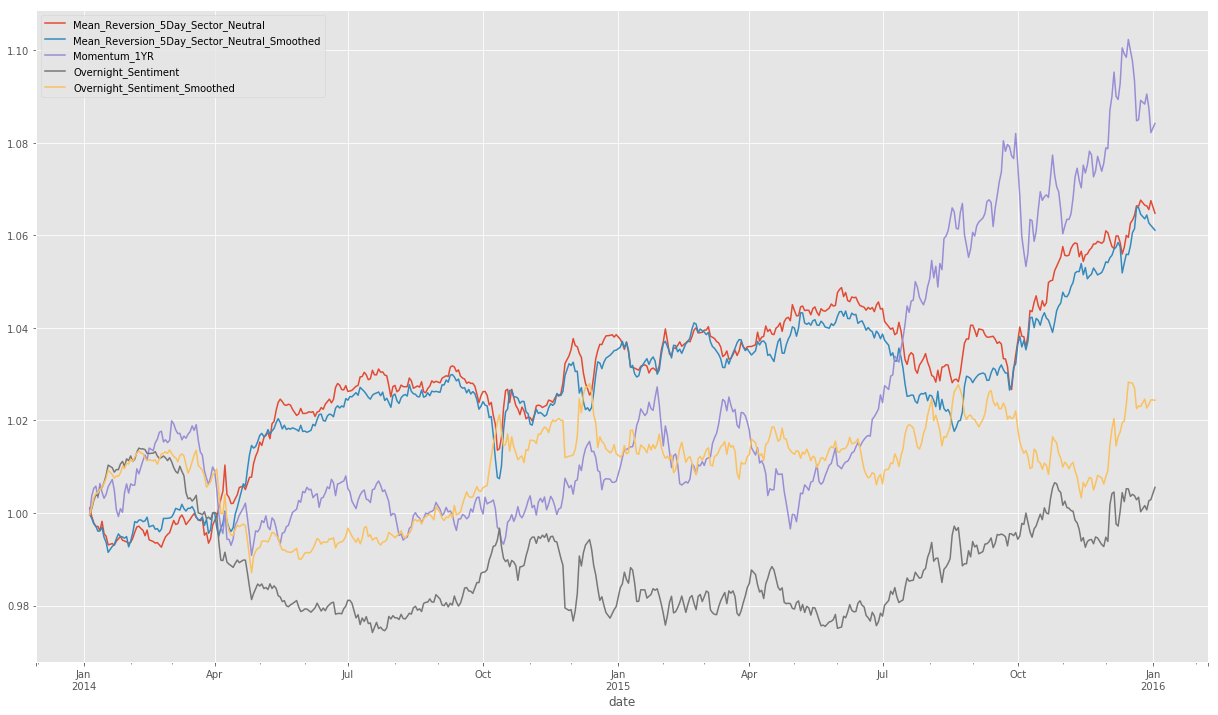

In [34]:
ls_factor_returns = pd.DataFrame()

for factor, factor_data in clean_factor_data.items():
    ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]

(1+ls_factor_returns).cumprod().plot()

### Basis Points Per Day per Quantile(因子每日5分位基点回报率)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0701bbc518>,
      dtype=object)

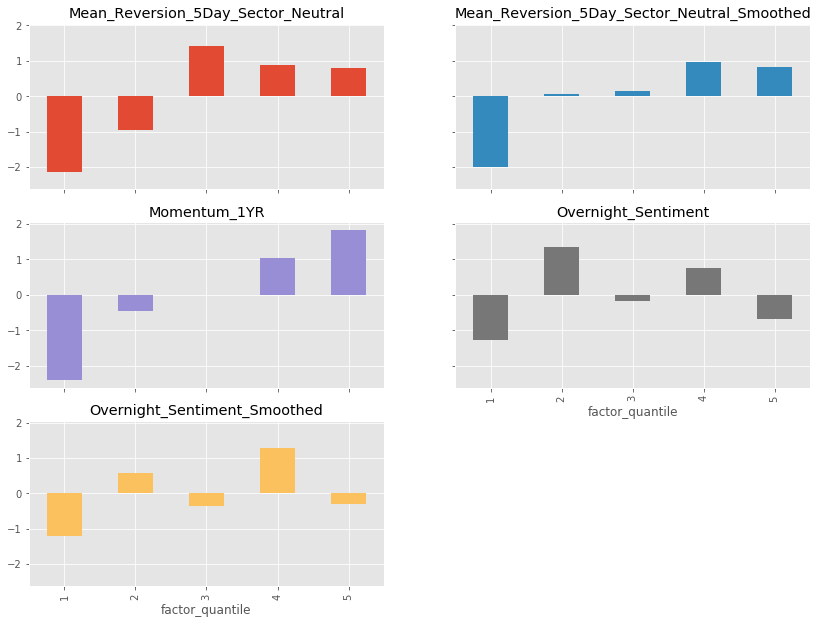

In [35]:
qr_factor_returns = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    qr_factor_returns[factor] = al.performance.mean_return_by_quantile(factor_data)[0].iloc[:, 0]

(10000*qr_factor_returns).plot.bar(
    subplots=True,
    sharey=True,
    layout=(4,2),
    figsize=(14, 14),
    legend=False)

我们可以发现

- 这些alpha因子不存在严格意义上的单调性
- 大多数回报都集中在"做空"的一端。第一分位的负值最大，但是需要考虑到可做空性及做空成本。
- 而且基点的回报范围(return spread)非常小，均小于4，需要再考率成本的前提下，适当加杠杆才有可能得到合适的回报率。

## Turnover Analysis(仓位调节频率分析)

如果alpha不够稳定，频繁调节仓位可能会导致成本过高。当回报率相同的前提下，我们倾向与选择，Alpha大小顺序变化较小的因子。此处我们将用**factor rank autocorrelation (FRA)**
进行评估。此数值越接近于1，表示仓位需要变动越小。

[alphalens.performance.factor_rank_autocorrelation](https://quantopian.github.io/alphalens/alphalens.html?highlight=factor_rank_autocorrelation#alphalens.performance.factor_rank_autocorrelation)

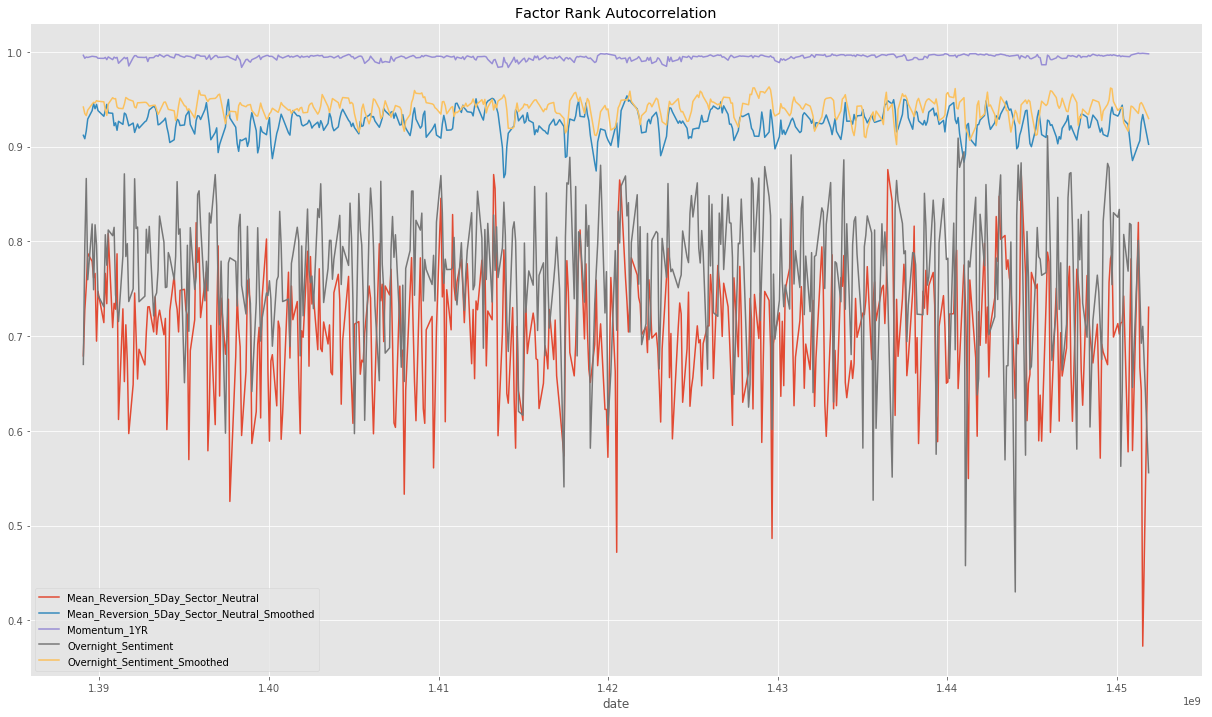

In [36]:
ls_FRA = pd.DataFrame()

for factor, factor_data in unixt_factor_data.items():
    ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

ls_FRA.plot(title="Factor Rank Autocorrelation")

## Sharpe Ratio of the Alphas(夏普率分析)

In [37]:
def sharpe_ratio(factor_returns, annualization_factor):
    """
    Get the sharpe ratio for each factor for the entire period

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns for each factor and date
    annualization_factor: float
        Annualization Factor

    Returns
    -------
    sharpe_ratio : Pandas Series of floats
        Sharpe ratio
    """
    sharpe_ratio = annualization_factor*factor_returns.mean() / factor_returns.std()
    
    return sharpe_ratio

### View Data(各因子夏普率概览)
通常来说，夏普率大于1或者更高的因子才可能作为单个alpha因子使用

In [38]:
daily_annualization_factor = np.sqrt(252)
sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2)

Mean_Reversion_5Day_Sector_Neutral             1.37
Mean_Reversion_5Day_Sector_Neutral_Smoothed    1.27
Momentum_1YR                                   1.13
Overnight_Sentiment                            0.12
Overnight_Sentiment_Smoothed                   0.45
dtype: float64

## The Combined Alpha Vector(结合因子)

结合因子方式有很多，可以用AI技术进行因子结合，在这里，我们选取因子Mean_Reversion_5Day_Sector_Neutral_Smoothed，Momentum_1YR，Overnight_Sentiment_Smoothed因子均值简单的结合。

In [39]:
selected_factors = all_factors.columns[[1, 2, 4]]
print('Selected Factors: {}'.format(', '.join(selected_factors)))

all_factors['alpha_vector'] = all_factors[selected_factors].mean(axis=1)
alphas = all_factors[['alpha_vector']]
alpha_vector = alphas.loc[all_factors.index.get_level_values(0)[-1]]
alpha_vector.head()

Selected Factors: Mean_Reversion_5Day_Sector_Neutral_Smoothed, Momentum_1YR, Overnight_Sentiment_Smoothed


,alpha_vector
asset,
Equity(0 [A]),-0.586425
Equity(1 [AAL]),-0.453338
Equity(2 [AAP]),-0.699939
Equity(3 [AAPL]),-0.067910
Equity(4 [ABBV]),-1.216179


现在alpha模型和风险模型已经设定完毕。我将建立一个最优控制器去在控制风险的情况下，实现alpha模型。

# Optimal Portfolio Constrained by Risk Model(优化投资组合并使用风险模型控制风险)

In [40]:
from abc import ABC, abstractmethod


class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=500)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

## Objective and Constraints(确认优化目标及约束条件)

The `_get_obj` function should return an CVXPY objective function that maximizes $ \alpha^T * x \\ $, where $ x $ is the portfolio weights and $ \alpha $ is the alpha vector.

The `_get_constraints` function should return a list of the following constraints:
- $ r \leq risk_{\text{cap}}^2 \\ $
- $ B^T * x \preceq factor_{\text{max}} \\ $
- $ B^T * x \succeq factor_{\text{min}} \\ $
- $ x^T\mathbb{1} = 0 \\ $
- $ \|x\|_1 \leq 1 \\ $
- $ x \succeq weights_{\text{min}} \\ $
- $ x \preceq weights_{\text{max}} $

Where $ x $ is the portfolio weights, $ B $ is the factor betas, and $ r $ is the portfolio risk

The first constraint is that the predicted risk be less than some maximum limit. The second and third constraints are on the maximum and minimum portfolio factor exposures. The fourth constraint is the "market neutral constraint: the sum of the weights must be zero. The fifth constraint is the leverage constraint: the sum of the absolute value of the weights must be less than or equal to 1.0. The last are some minimum and maximum limits on individual holdings.

In [41]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        objective = cvx.Maximize(alpha_vector[alpha_vector.columns[0]].values*weights)
        return objective
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        f = np.array(factor_betas.T) * weights
        
        constraints = [risk <= self.risk_cap**2,
                       f <= self.factor_max,
                       f >= self.factor_min,
                       sum(weights) ==0.0,
                       sum(cvx.abs(weights))<= 1.0,
                       weights >= self.weights_min,
                       weights <= self.weights_max]

        return constraints

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

### View Data(概览控制风险后的分配权重及投资组合Factor Exposures)

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


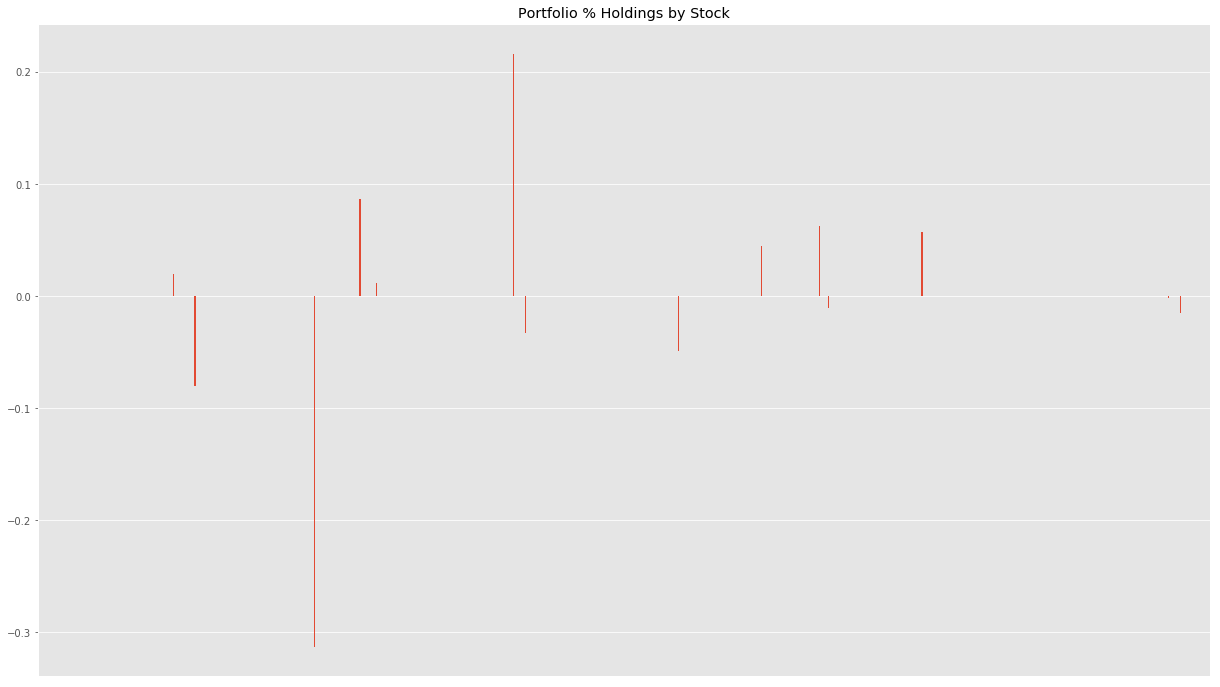

In [42]:
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

权重集中到几支很少的股票上，这不是我们想要的结果。

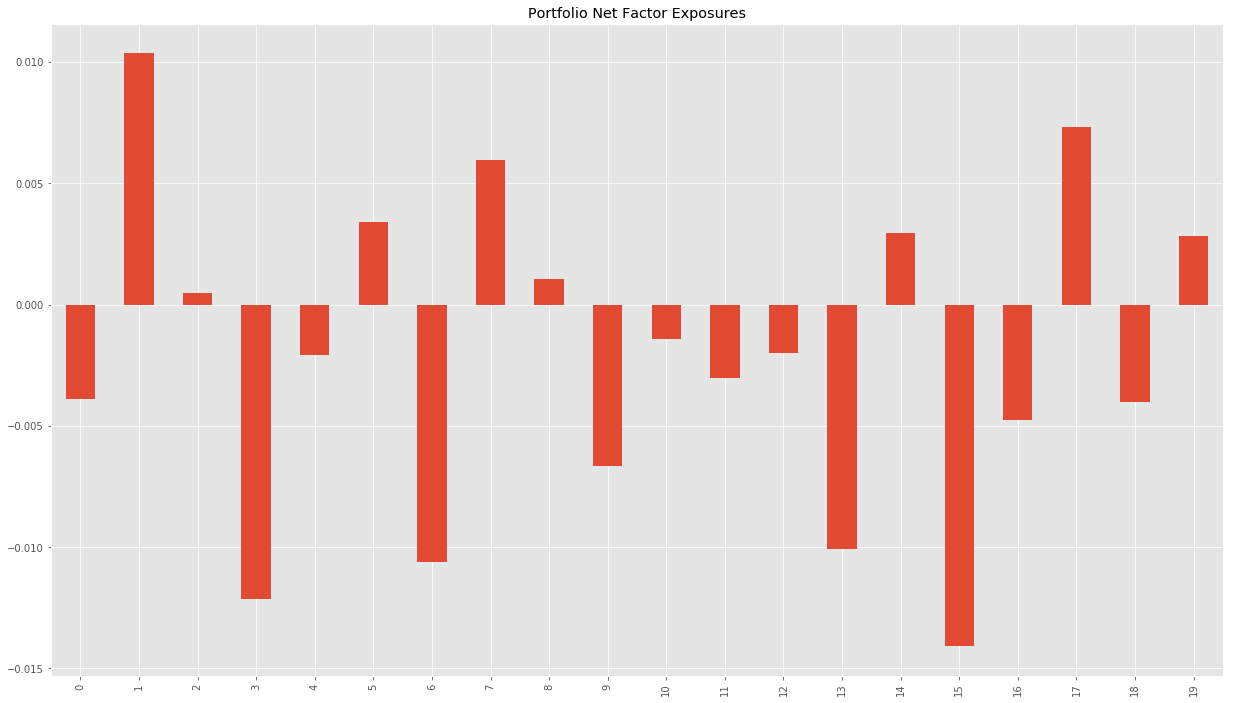

In [43]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Regularization Parameter(添加正则化参数优化)
我们需要将集中的权重分散，我们将在目标公式中加入正则化参数

设定`_get_obj` 为 $ \alpha^T * x + \lambda\|x\|_2\\ $

$ x $为组合权重, $ \alpha $为alpha因子, $ \lambda $是正则化参数

In [44]:
class OptimalHoldingsRegualization(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        objective = cvx.Maximize(np.array(alpha_vector.T)*weights - \
                                 self.lambda_reg * cvx.norm(weights, 2)
                                )
        return objective

    def __init__(self, lambda_reg=0.5, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


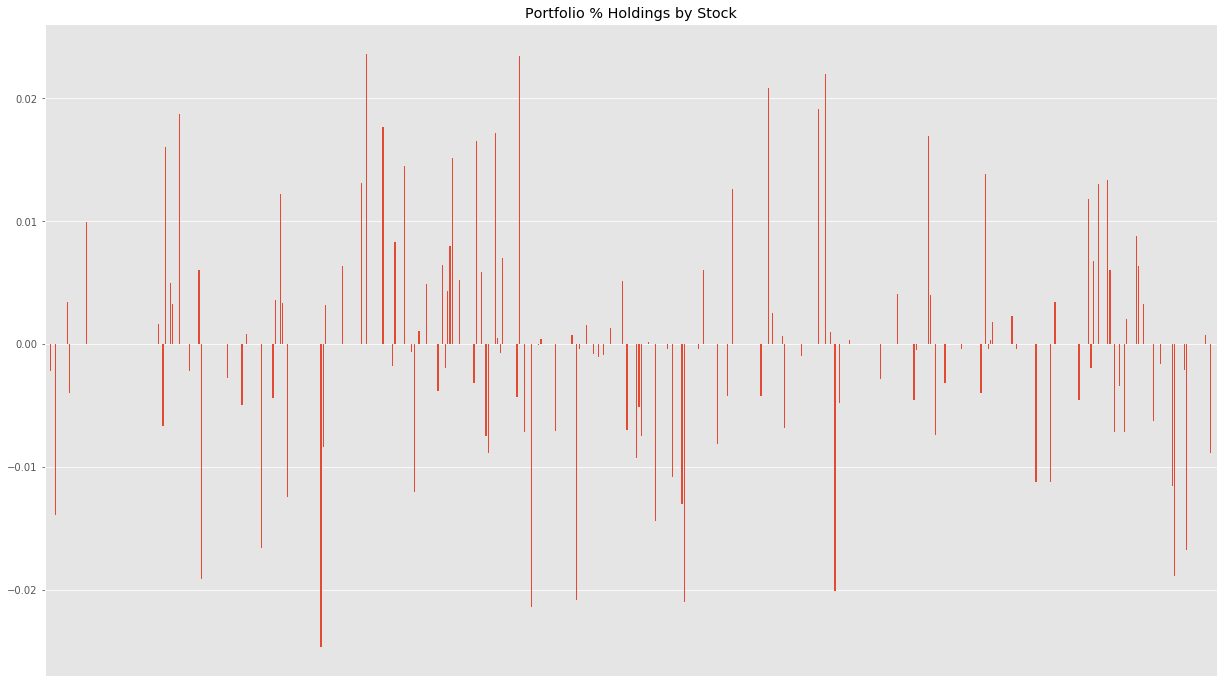

In [45]:
optimal_weights_1 = OptimalHoldingsRegualization(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

现在权重分配更加合理分散化了。

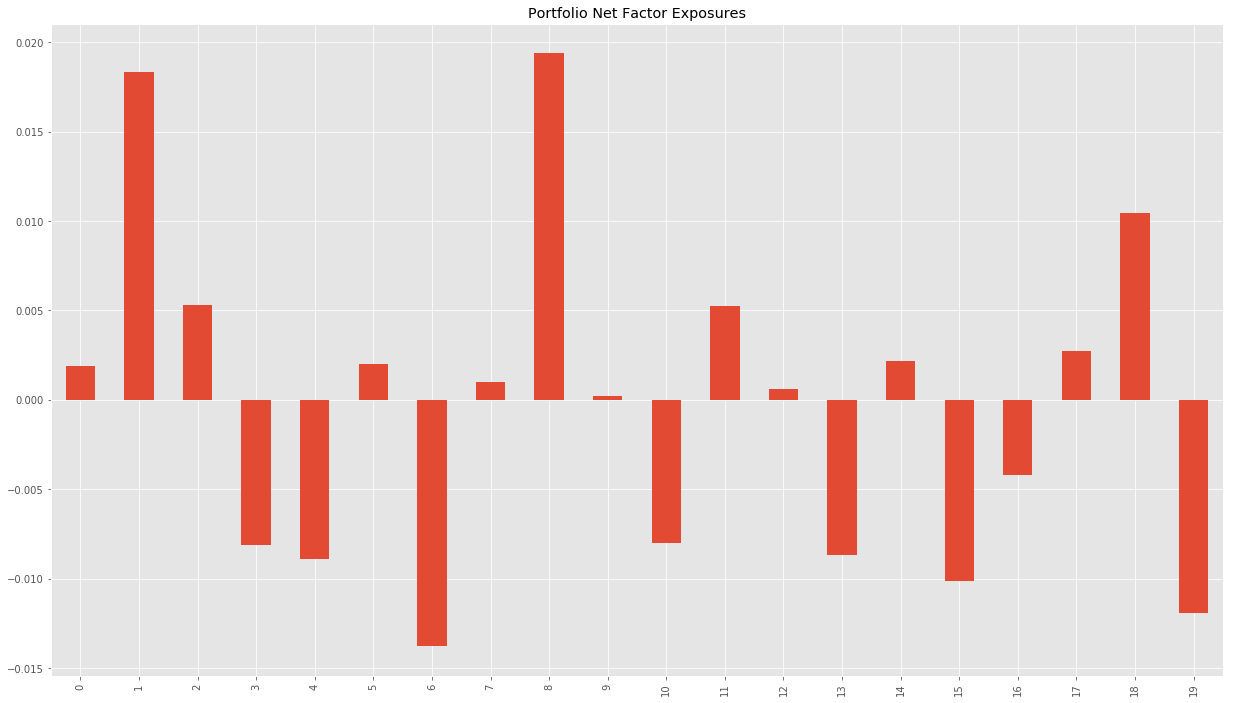

In [46]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_1).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)

## Optimize with a Strict Factor Constraints and Target Weighting(目标权重优化)
在严格执行各项约束，向目标权重靠拢

In [47]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        x = np.array(alpha_vector)
        x_star = (x - x.mean())/sum(abs(x))
        
        objective = cvx.Minimize(cvx.norm(weights-x_star.reshape(len(x_star),),2))
        
        return objective

### View Data

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


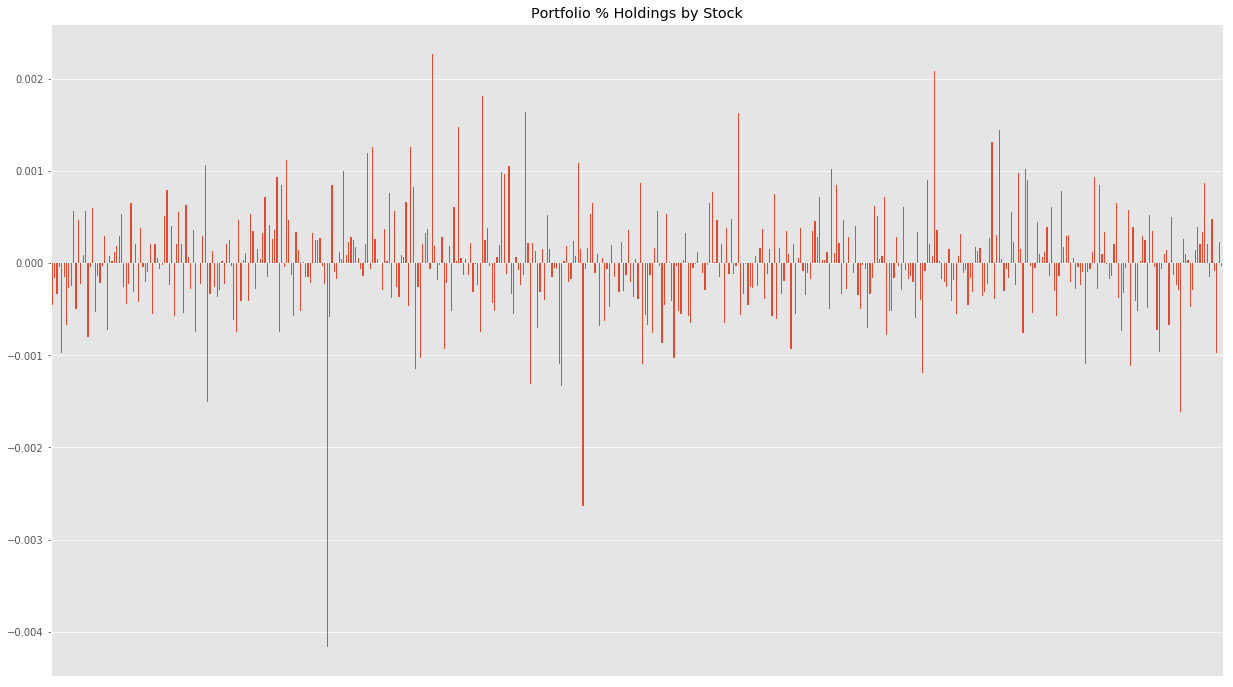

In [48]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.0015,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)

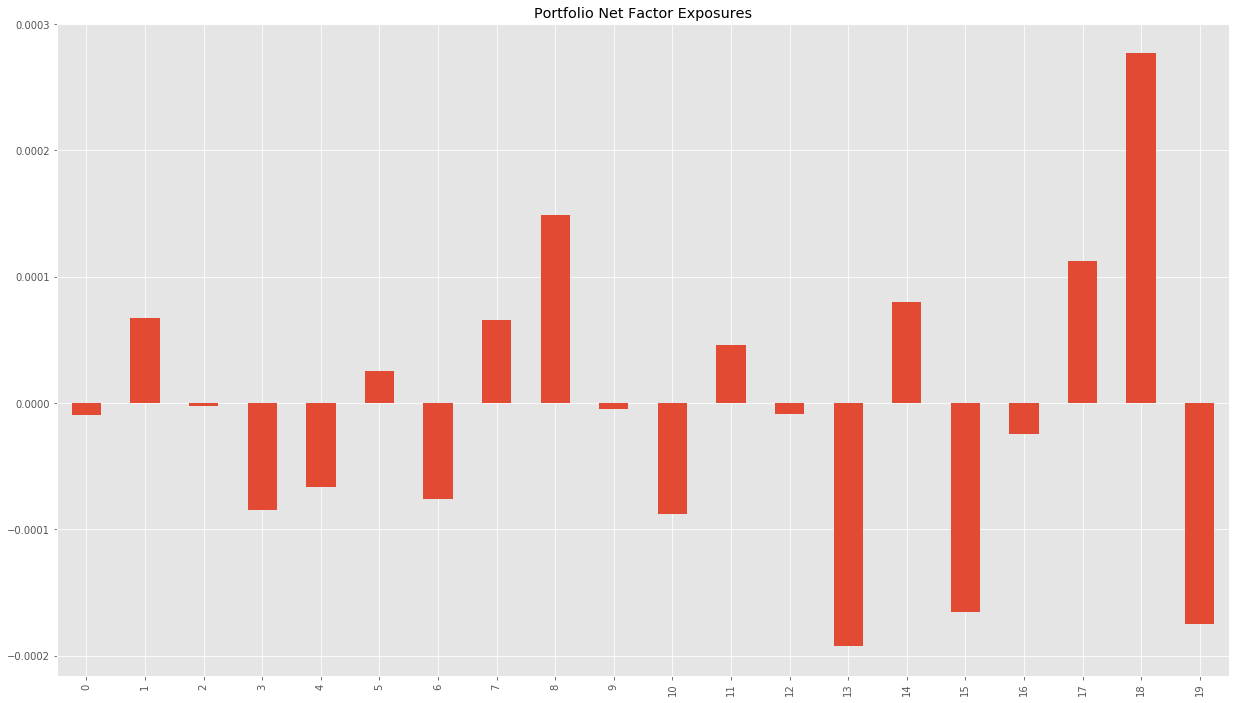

In [49]:
project_helper.get_factor_exposures(risk_model['factor_betas'], optimal_weights_2).plot.bar(
    title='Portfolio Net Factor Exposures',
    legend=False)